In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations for the training and testing data
transform = transforms.Compose([transforms.ToTensor()])

# Load the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 22379327.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1046131.01it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9154700.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2893458.20it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(self.conv2(x), 2)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and the optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.0058
Epoch [2/5], Loss: 0.0014
Epoch [3/5], Loss: 0.0030
Epoch [4/5], Loss: 0.0071
Epoch [5/5], Loss: 0.0462


In [3]:
def pgd_attack(model, images, labels, epsilon=0.1, alpha=0.01, num_iter=10):
    original_images = images.clone().detach()
    perturbed_images = images.clone().detach().requires_grad_(True)
    
    for _ in range(num_iter):
        outputs = model(perturbed_images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            perturbed_images += alpha * perturbed_images.grad.sign()
            perturbation = torch.clamp(perturbed_images - original_images, min=-epsilon, max=epsilon)
            perturbed_images = torch.clamp(original_images + perturbation, 0, 1)
        
        perturbed_images.requires_grad_(True)
    
    return perturbed_images


Accuracy of the model on the normal test data: 98.75%
Accuracy of the model on the PGD adversarial examples: 37.41%


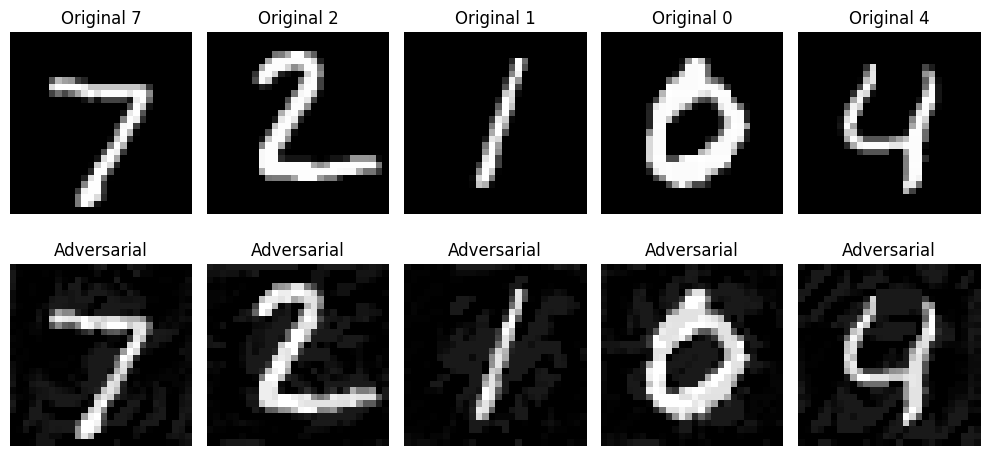

In [4]:
import matplotlib.pyplot as plt

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def evaluate_pgd(model, data_loader, epsilon=0.1, alpha=0.01, num_iter=10):
    correct = 0
    total = 0
    
    for images, labels in data_loader:
        images, labels = images.to('cpu'), labels.to('cpu')
        perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def visualize_pgd(model, data_loader, epsilon=0.1, alpha=0.01, num_iter=10):
    model.eval()
    images, labels = next(iter(data_loader))
    perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
    
    num_images = min(5, len(images))
    fig, axes = plt.subplots(2, num_images, figsize=(10, 5))
    
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze().detach().numpy(), cmap='gray')
        axes[0, i].set_title(f"Original {labels[i].item()}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(perturbed_images[i].squeeze().detach().numpy(), cmap='gray')
        axes[1, i].set_title(f"Adversarial")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Evaluate and visualize the normal and PGD results
epsilon = 0.1
alpha = 0.01
num_iter = 10

# Normal accuracy
normal_accuracy = evaluate(model, test_loader)
print(f'Accuracy of the model on the normal test data: {normal_accuracy:.2f}%')

# PGD accuracy
pgd_accuracy = evaluate_pgd(model, test_loader, epsilon, alpha, num_iter)
print(f'Accuracy of the model on the PGD adversarial examples: {pgd_accuracy:.2f}%')

# Visualize original and adversarial images
visualize_pgd(model, test_loader, epsilon, alpha, num_iter)
